In [1]:
# import os
# os.environ['http_proxy'] = 'http://127.0.0.1:7890'
# os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [2]:
import subprocess
import os
os.environ['CURL_CA_BUNDLE'] = ''

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [4]:
from torch import bfloat16
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

## Overall

- HuggingFace bitsandbytes
- GPTQ: data **compression**, GPU，https://arxiv.org/pdf/2210.17323
    - GPTQ is a **post-training quantization (PTQ)** method for 4-bit quantization that focuses primarily on **GPU** inference and performance.
    - to quantizing the weights of transformer-based models
    - first applies scalar quant to the weights, followed by vector quant to the residuals
    - The idea behind the method is that it will try to **compress all weights to a 4-bit quantization** by minimizing the **mean squared error** to that weight.
        - During inference, it will dynamically dequantize its weights to float16 for improved performance whilst keeping memory low.
- GGUF: ggml, CPU
    - c++, 
    - llama.cpp, https://github.com/ggerganov/llama.cpp
- AWQ：activation aware quantization，https://arxiv.org/abs/2306.00978

## Examples

In [4]:
# Load in your LLM without any compression tricks
model_id = "meta-llama/Meta-Llama-3-8B-Instruct" 
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=bfloat16,
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
pipe.model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [6]:
q_proj = pipe.model.model.layers[0].self_attn.q_proj.weight.detach().to(torch.float16).cpu().numpy().flatten()

<Axes: ylabel='Count'>

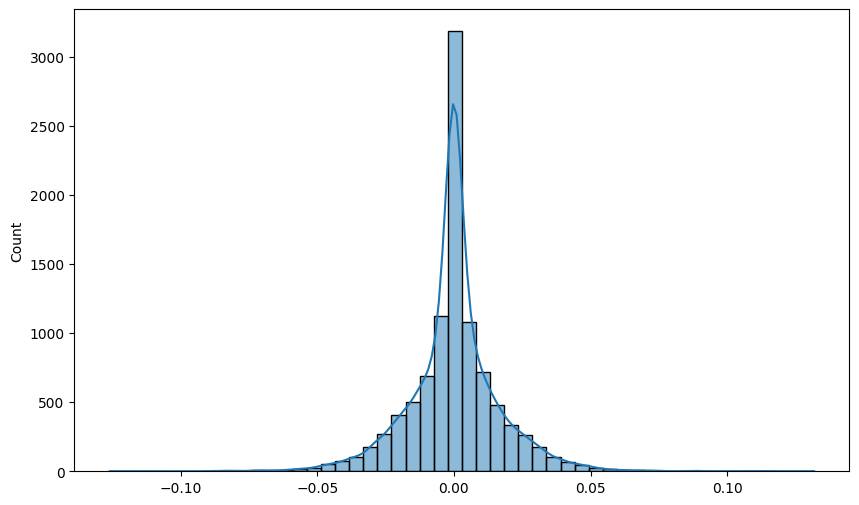

In [7]:
plt.figure(figsize=(10, 6))
# 可以发现基本是集中在均值 0 附近
sns.histplot(q_proj[:10000], bins=50, kde=True)

## Chat template

- llama3
    - `<|begin_of_text|>`
    - `<|start_header_id|>system<|end_header_id|>....<|eot_id|>`
    - `<|start_header_id|>user<|end_header_id|>...<|eot_id|>`
    - `<|start_header_id|>assistant<|end_header_id|>...`
- zephyr（部分其他模型）
    - `<|system|> ... </s>`
    - `<|user|> ... </s>`
    - `<|assistant|> ... </s>`

In [8]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [9]:
T = AutoTokenizer.from_pretrained(model_id)
T

PreTrainedTokenizerFast(name_or_path='meta-llama/Meta-Llama-3-8B-Instruct', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|reserved_special_token_2|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128005: AddedToken(

In [10]:
T.encode('<|system|>')

[128000, 27, 91, 9125, 91, 29]

In [11]:
Image(url='imgs/prompt_template.png', width=700)

In [12]:
prompt

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nTell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

## Generation

In [13]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [14]:
torch.cuda.max_memory_allocated(device='cuda:0') / (1024*1024*1024)

14.988792896270752

In [15]:
print(outputs[0]['generated_text'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Why did the Large Language Model go to therapy?

Because it was feeling a little "dis-connected" and was struggling to "process" its emotions!


## Sharding

In [16]:
os.environ['NCCL_P2P_DISABLE'] = "1"
os.environ['NCCL_IB_DISABLE'] = "1"

In [17]:
from accelerate import Accelerator

# Shard our model into pieces
accelerator = Accelerator()
accelerator.save_model(
    model=pipe.model,
    save_directory="./model",
    max_shard_size="4GB"
)

[2024-11-13 14:01:00,907] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Quant

- 4bit-NormalFloat (NF4, **qlora: lora on a quantize LLMs**， https://arxiv.org/abs/2305.14314) consists of three steps:
    - Normalization: The weights of the model are normalized so that we expect the weights to fall within **a certain range**. This allows for more efficient representation of more common values.
        - The weights of the model are **first normalized to have zero mean and unit variance**. This ensures that the weights are **distributed around zero** and fall within a certain range.
    - Quantization: The weights are **quantized to 4-bit**. In NF4, the quantization levels are evenly spaced with respect to the normalized weights, thereby efficiently representing the original 32-bit weights.
        - The normalized weights are then quantized to 4 bits. This involves mapping the original high-precision weights to a smaller set of low-precision values. In the case of NF4, the quantization levels are chosen to be **evenly spaced** in the range of the normalized weights.
    - Dequantization: Although the weights are stored in 4-bit, they are dequantized during computation which gives a performance boost during inference.
        - During the forward pass and backpropagation, the quantized weights are **dequantized back to full precision**. This is done by mapping the 4-bit quantized values back to their original range. The dequantized weights are used in the computations, but they are stored in memory in their 4-bit quantized form.
- bitsandbytes 的分位数计算
    - 密度高的地方多分配，密度低的地方少分配
    - https://github.com/bitsandbytes-foundation/bitsandbytes/blob/main/bitsandbytes/functional.py#L267
    - https://zhuanlan.zhihu.com/p/647378373

In [20]:
Image(url='imgs/data_precision.png', width=700)

In [23]:
Image(url='imgs/data_precision_example.png', width=500)

In [24]:
torch.set_printoptions(sci_mode=False)
X = torch.tensor([0.1234, 75535])

print(X, X.dtype)  # 默认为 float32
print(X.to(torch.float16))
print(X.to(torch.bfloat16))

tensor([    0.1234, 75535.0000]) torch.float32
tensor([0.1234,    inf], dtype=torch.float16)
tensor([    0.1235, 75776.0000], dtype=torch.bfloat16)


In [35]:
# Delete any models previously created
# del pipe, accelerator

# Empty VRAM cache
import gc
gc.collect()
torch.cuda.empty_cache()

In [1]:
from transformers import BitsAndBytesConfig
from torch import bfloat16
model_id = "meta-llama/Meta-Llama-3-8B-Instruct" 

# Our 4-bit configuration to load the LLM with less GPU memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,               # 4-bit quantization
    bnb_4bit_quant_type='nf4',       # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

In [5]:
# With BitsAndBytes Configuration
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
torch.cuda.max_memory_allocated('cuda:0') / (1024*1024*1024)

5.42464542388916

In [7]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [8]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a friendly chatbot.<|eot_id|><|start_header_id|>user<|end_header_id|>

Tell me a funny joke about Large Language Models.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Why did the Large Language Model go to therapy?

Because it was struggling to "process" its emotions and was feeling a little "disconnected"!


In [9]:
torch.cuda.max_memory_allocated('cuda:0') / (1024*1024*1024)

5.544897556304932

注意，这里的量化是不完全量化。

例如，load_in_4bit：
- embed_tokens 继续是 torch.float16
- 每个 layer 的内部（self attention）以及 mlp 部分是 uint8
- 每个 layer 的 output（layernorm）部分是 float16（如果 load 时传入了 `torch_dtype=torch.bfloat16`，则这部分为 torch.bfloat16）
- 同理适用于 load_in_8bit

In [10]:
for name, para in pipe.model.named_parameters():
    print(name, para.dtype, para.shape, para.device)

model.embed_tokens.weight torch.float16 torch.Size([128256, 4096]) cuda:0
model.layers.0.self_attn.q_proj.weight torch.uint8 torch.Size([8388608, 1]) cuda:0
model.layers.0.self_attn.k_proj.weight torch.uint8 torch.Size([2097152, 1]) cuda:0
model.layers.0.self_attn.v_proj.weight torch.uint8 torch.Size([2097152, 1]) cuda:0
model.layers.0.self_attn.o_proj.weight torch.uint8 torch.Size([8388608, 1]) cuda:0
model.layers.0.mlp.gate_proj.weight torch.uint8 torch.Size([29360128, 1]) cuda:0
model.layers.0.mlp.up_proj.weight torch.uint8 torch.Size([29360128, 1]) cuda:0
model.layers.0.mlp.down_proj.weight torch.uint8 torch.Size([29360128, 1]) cuda:0
model.layers.0.input_layernorm.weight torch.float16 torch.Size([4096]) cuda:0
model.layers.0.post_attention_layernorm.weight torch.float16 torch.Size([4096]) cuda:0
model.layers.1.self_attn.q_proj.weight torch.uint8 torch.Size([8388608, 1]) cuda:0
model.layers.1.self_attn.k_proj.weight torch.uint8 torch.Size([2097152, 1]) cuda:0
model.layers.1.self_at

## GPTQ

In [11]:
# Delete any models previously created
del tokenizer, model, pipe

# Empty VRAM cache
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

- https://huggingface.co/MaziyarPanahi/Meta-Llama-3-8B-Instruct-GPTQ
- https://github.com/AutoGPTQ/AutoGPTQ （可以走源码安装）

```
# GPTQ Dependencies
# !pip install optimum
# !pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/
```

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load LLM and Tokenizer
model_id = "MaziyarPanahi/Meta-Llama-3-8B-Instruct-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

In [ ]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

In [ ]:
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.1,
    top_p=0.95
)
print(outputs[0]["generated_text"])

In [ ]:
torch.cuda.max_memory_allocated('cuda:0') / (1024*1024*1024)

## GGUF

- GPT-Generated Unified Format，是由Georgi Gerganov定义发布的一种大模型文件格式。Georgi Gerganov是著名开源项目llama.cpp的创始人。
    - GGML：GPT-Generated Model Language
- Although GPTQ does compression well, its **focus on GPU** can be a disadvantage if you do not have the hardware to run it.
    - GGUF, previously GGML, is a quantization method that allows users to **use the CPU to run an LLM** but also **offload some of its layers to the GPU** for a speed up (`llama.cpp` 中的 `-ngl` ). Although using the CPU is generally slower than using a GPU for inference, it is an incredible format for those running models on CPU or Apple devices.
    - Especially since we are seeing smaller and more capable models appearing, like Mistral 7B, the GGUF format might just be here to stay!
- Q4_K_M
    - Q stands for Quantization.
    - 4 indicates the number of bits used in the quantization process.
    - K refers to the use of **k-means** clustering in the quantization.
    - M represents the size of the model after quantization.
        - (S = Small, M = Medium, L = Large).

### quant base kmeans clustering

In [12]:
Image(url='imgs/quant-clustering.jpeg', width=400)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# 原始权重矩阵
weights = np.array([
    [2.09, -0.98, 1.48, 0.09],
    [0.05, -0.14, -1.08, 2.12],
    [-0.91, 1.92, 0, -1.03],
    [1.87, 0, 1.53, 1.49]
])

# K-means聚类
kmeans = KMeans(n_clusters=4)
kmeans.fit(weights.reshape(-1, 1))
cluster_indices = kmeans.predict(weights.reshape(-1, 1)).reshape(weights.shape)
centroids = kmeans.cluster_centers_.flatten()

# 根据质心值排序
sorted_indices = np.argsort(centroids)
sorted_centroids = centroids[sorted_indices]

# 创建索引映射
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}

# 更新量化索引矩阵
new_cluster_indices = np.vectorize(index_map.get)(cluster_indices)

print("重新排序后的量化索引矩阵：\n", new_cluster_indices)
print("重新排序后的质心值：\n", sorted_centroids)

### gguf

In [ ]:
del tokenizer, model, pipe

# Empty VRAM cache
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from ctransformers import AutoModelForCausalLM
from transformers import AutoTokenizer, pipeline

# Load LLM and Tokenizer
# Use `gpu_layers` to specify how many layers will be offloaded to the GPU.
model = AutoModelForCausalLM.from_pretrained(
    "QuantFactory/Meta-Llama-3-8B-Instruct-GGUF",
    model_file="Meta-Llama-3-8B-Instruct.Q4_K_M.gguf",
    # model_type="llama", 
    gpu_layers=20, hf=True
)
tokenizer = AutoTokenizer.from_pretrained(
    "QuantFactory/Meta-Llama-3-8B-Instruct-GGUF", use_fast=True
)

# Create a pipeline
pipe = pipeline(model=model, tokenizer=tokenizer, task='text-generation')

## AWQ


A new format on the block is AWQ ([Activation-aware Weight Quantization](https://arxiv.org/abs/2306.00978)) which is a quantization method similar to GPTQ. There are several differences between AWQ and GPTQ as methods but the most important one is that AWQ assumes that **not all weights are equally important for an LLM's performance**.

In other words, there is a small fraction of weights that will be skipped during quantization which helps with the quantization loss.

As a result, their paper mentions a **significant speed-up compared to GPTQ whilst keeping similar, and sometimes even better, performance.**

In [ ]:
from vllm import LLM, SamplingParams

# Load the LLM
sampling_params = SamplingParams(temperature=0.0, top_p=1.0, max_tokens=256)
llm = LLM(
    model="casperhansen/llama-3-8b-instruct-awq",
    quantization='awq',
    dtype='half',
    gpu_memory_utilization=.95,
    max_model_len=4096
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("casperhansen/llama-3-8b-instruct-awq")

In [ ]:
# See https://huggingface.co/docs/transformers/main/en/chat_templating
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot.",
    },
    {
        "role": "user",
        "content": "Tell me a funny joke about Large Language Models."
    },
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
print(prompt)

In [ ]:
# Generate output based on the input prompt and sampling parameters
output = llm.generate(prompt, sampling_params)
print(output[0].outputs[0].text)